# Chapter 10 - Forecasting multiple time series 
* Examining the `VAR model `
* Exploring `Granger casality` to validate the use of the VAR model 
* Forecasting multiple time series using the VAR model 

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from pathlib import Path

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# omd
import datetime
import importlib
import sys

sys.path.append('../../My-Code/')

import timetools as tt
import omdutils as omd

importlib.reload(tt)

path = Path('/home/oliver/Documents/Data')
print('timetools version: {}'.format(tt.__version__))
print('omdutils version: {}'.format(omd.__version__))
print('statsmodels version: {}'.format(sm.__version__))

timetools version: 10.09.2022
omdutils version: 8.6.2022
statsmodels version: 0.13.2


In [2]:
df = omd.from_sqlite('select * from macro_econ_data', str(path / 'Datasets'))
df['date'] = pd.to_datetime(df['date']).dt.date
df.set_index('date', inplace=True)
df.head()

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
date,,,,,,,,,,,,
1959-01-01,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1959-04-01,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
1959-07-01,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
1959-10-01,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
1960-01-01,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


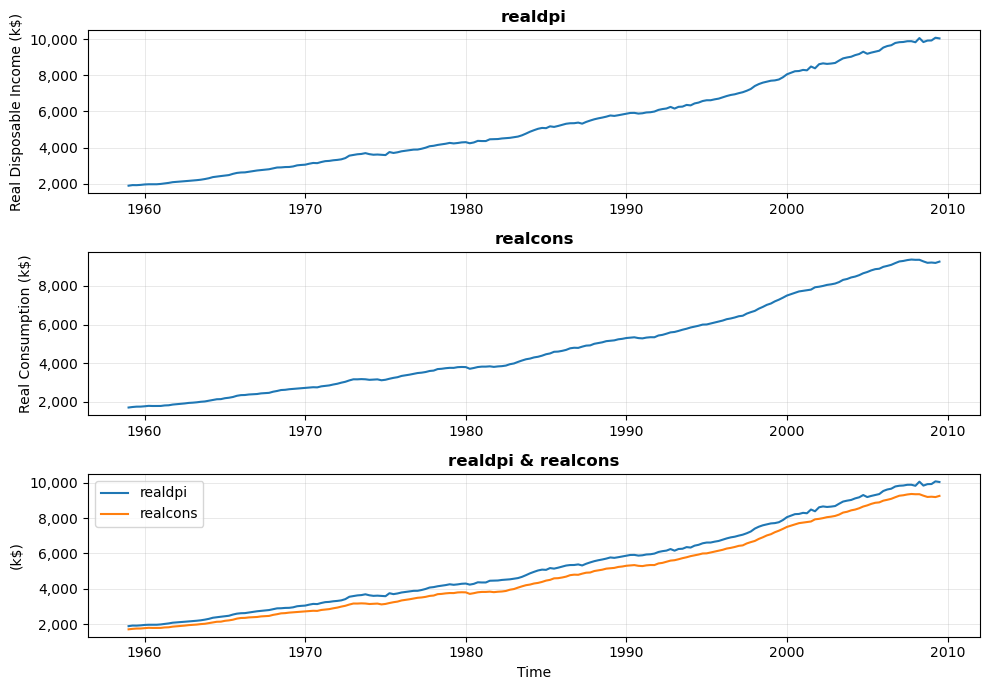

In [3]:
import matplotlib.ticker as mticker

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,7))
ax1.plot(df['realdpi'])
ax1.set_title('realdpi', fontweight='bold')
ax1.set_ylabel('Real Disposable Income (k$)')
ax1.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
ax1.grid(lw=0.5, alpha=0.4)

ax2.plot(df['realcons'])
ax2.set_title('realcons', fontweight='bold')
ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_ylabel('Real Consumption (k$)')
ax2.grid(lw=0.5, alpha=0.4)

ax3.plot(df['realdpi'], label='realdpi')
ax3.plot(df['realcons'], label='realcons')
ax3.set_title('realdpi & realcons', fontweight='bold')
ax3.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
ax3.set_ylabel('(k$)')
ax3.set_xlabel('Time')
ax3.grid(lw=0.5, alpha=0.4)
ax3.legend()

plt.tight_layout()

In [219]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

def crosscorr(exog, endog, lags, title='Cross Correlation'):
    backwards = sm.tsa.stattools.ccf(endog[::-1], exog[::-1], adjusted=False)[::-1]
    forwards = sm.tsa.stattools.ccf(endog, exog, adjusted=False)

    xcorr = np.r_[backwards[-lags-1:-1], forwards[:lags+1]] 
    xcorr = pd.DataFrame(xcorr, columns=['xcorrelation'])
    xcorr.index = np.arange(start=-lags, stop=lags+1)
    # print(xcorr)

    fig, ax = plt.subplots(1, 1, figsize=(25, 5))
    plt.bar(x=xcorr.index.tolist(), height=xcorr['xcorrelation'])
    plt.ylim(-1.3, 1.3)
    plt.title(title)
    plt.xlabel('Lags')
    plt.ylabel('Correlation')
    for index, value in xcorr.iterrows():    
        if value['xcorrelation'] >= 0:
            plt.text(x=index, y=value['xcorrelation'] + 0.02, s=str(round(value['xcorrelation'], 2)), ha='center')
        else:
            plt.text(x=index, y=value['xcorrelation'] - 0.07, s=str(round(value['xcorrelation'], 2)), ha='center')
    plt.tight_layout()

    xcorrelation
-4     -0.281596
-3     -0.060663
-2      0.193522
-1      0.462387
 0      0.771094
 1      0.868304
 2      0.755216
 3      0.489048
 4      0.122824


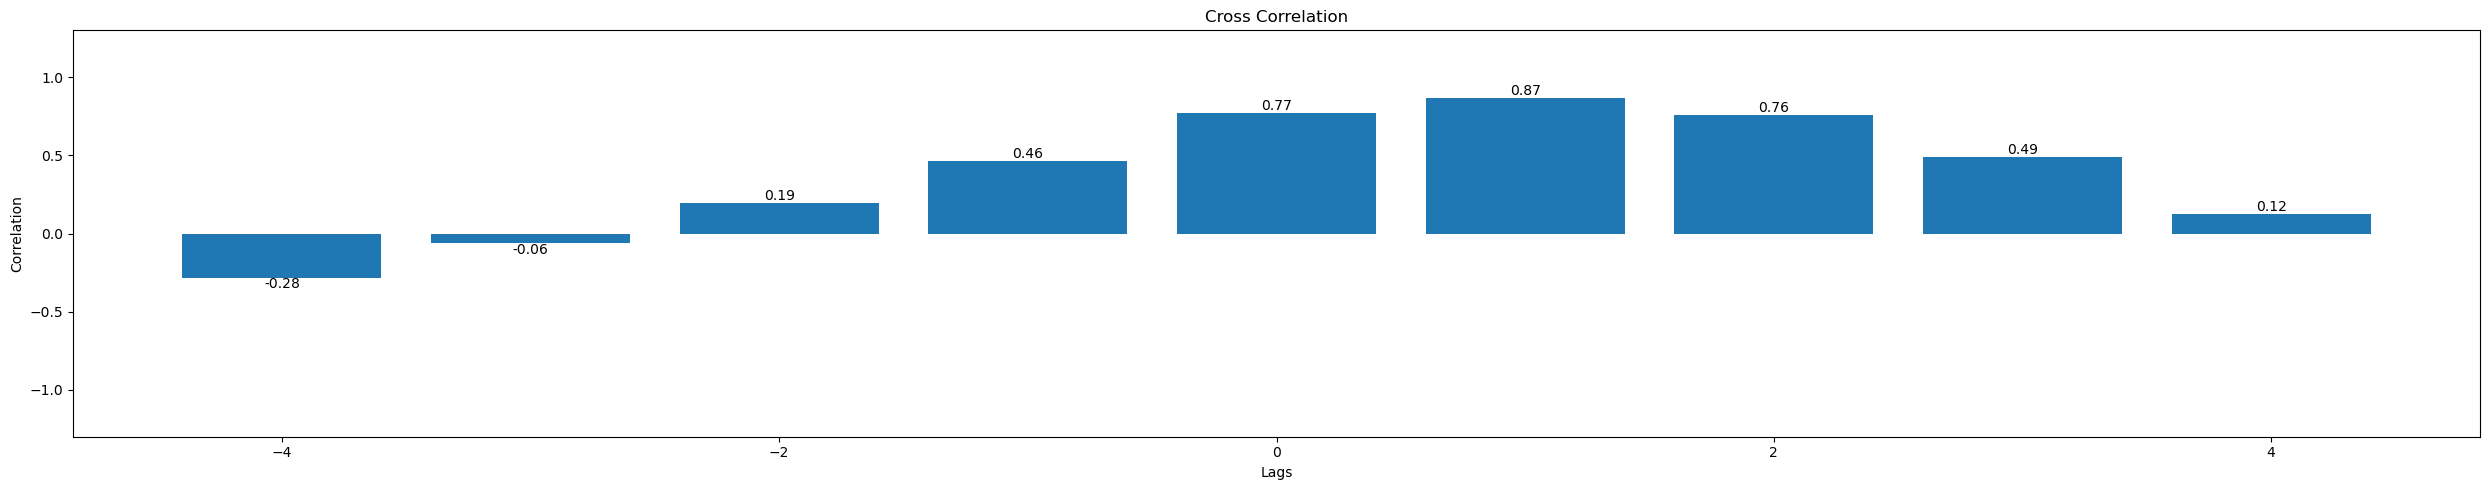

In [220]:
marketing = np.array([3, 4, 5, 5, 7, 9, 13, 15, 12, 10, 8, 8])
revenue = np.array([21, 19, 22, 24, 25, 29, 30, 34, 37, 40, 35, 30]) 
crosscorr(exog=marketing, endog=revenue, lags=4)

    xcorrelation
-5      0.927271
-4      0.941719
-3      0.956252
-2      0.970459
-1      0.984996
 0      0.999091
 1      0.984868
 2      0.970660
 3      0.956048
 4      0.941192
 5      0.925785


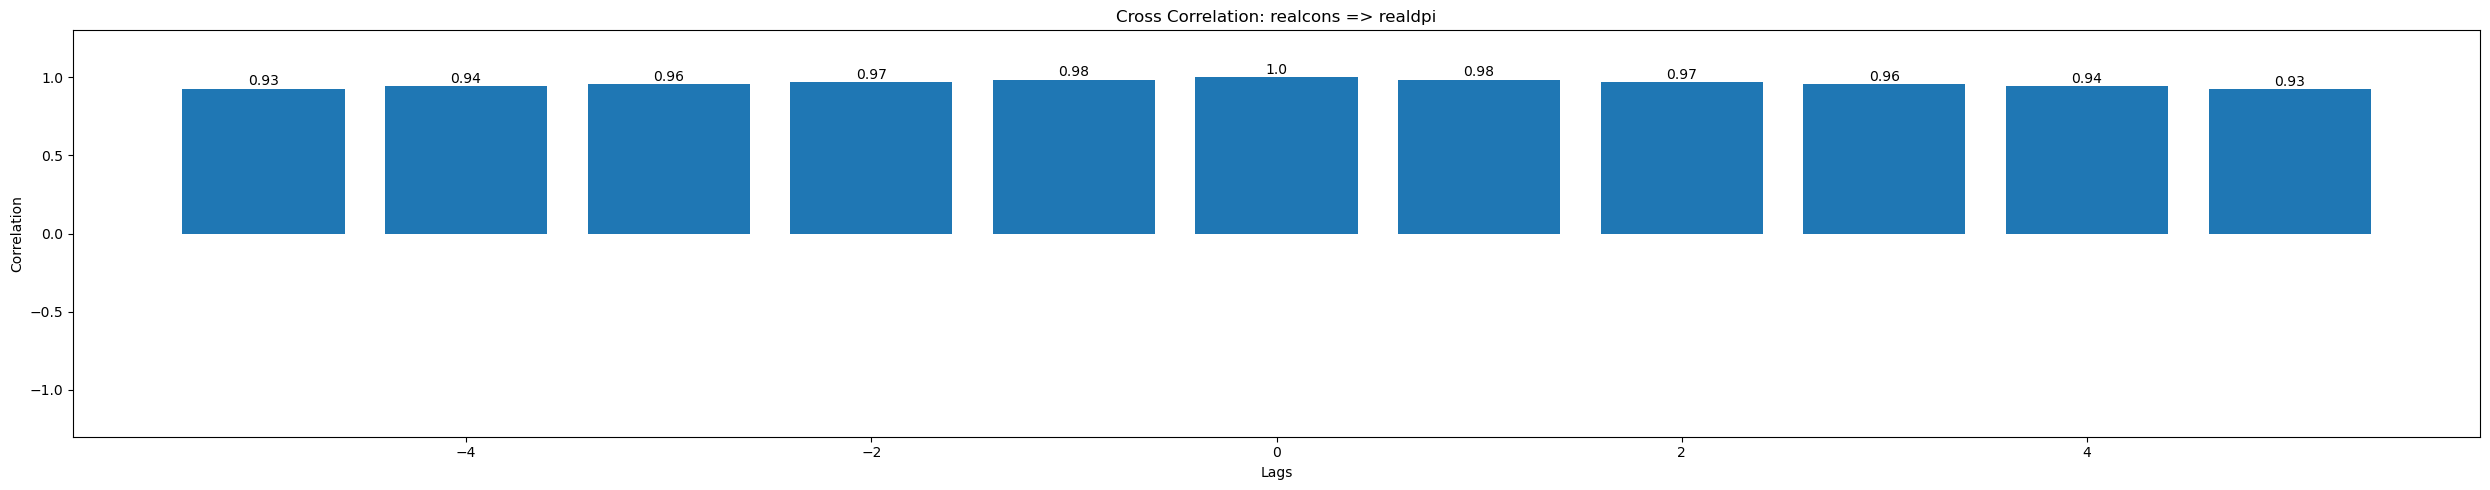

In [223]:
crosscorr(exog=df['realcons'], endog=df['realdpi'], lags=5, title='Cross Correlation: realcons => realdpi')

https://medium.com/@dreamferus/how-to-synchronize-time-series-using-cross-correlation-in-python-4c1fd5668c7a|

In [224]:
from scipy.signal import correlate
from scipy.signal import correlation_lags

# Function to calculate cross-correlation,
# extract the best matching shift and then shift
# one of the series appropriately.
def shift_for_maximum_correlation(x, y):
    correlation = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
    lag = lags[np.argmax(correlation)]
    print(f"Best lag: {lag}")
    if lag < 0:
        y = y.iloc[abs(lag):].reset_index(drop=True)
    else:
        x = x.iloc[lag:].reset_index(drop=True)
    return x, y

# Plot results after shifting
for x, y in shifted_versions:
    shifted_x, shifted_y = shift_for_maximum_correlation(x, y)
    plot_correlation(shifted_x, shifted_y, text="after shifting")

NameError: name 'shifted_versions' is not defined

In [31]:
df['realcons_pct_chg'] = df['realcons'].pct_change()
df['realdbi_pct_chg'] = df['realdpi'].pct_change()
df

,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,realcons_pct_chg,realdbi_pct_chg
date,,,,,,,,,,,,,,
1959-01-01,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00,NaN,NaN
1959-04-01,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74,0.015404,0.017383
1959-07-01,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09,0.010440,-0.001719
1959-10-01,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06,0.001085,0.007775
1960-01-01,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19,0.009580,0.012530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-07-01,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33,-0.008908,-0.021941
2008-10-01,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91,-0.007812,0.008345
2009-01-01,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71,0.001512,0.000605


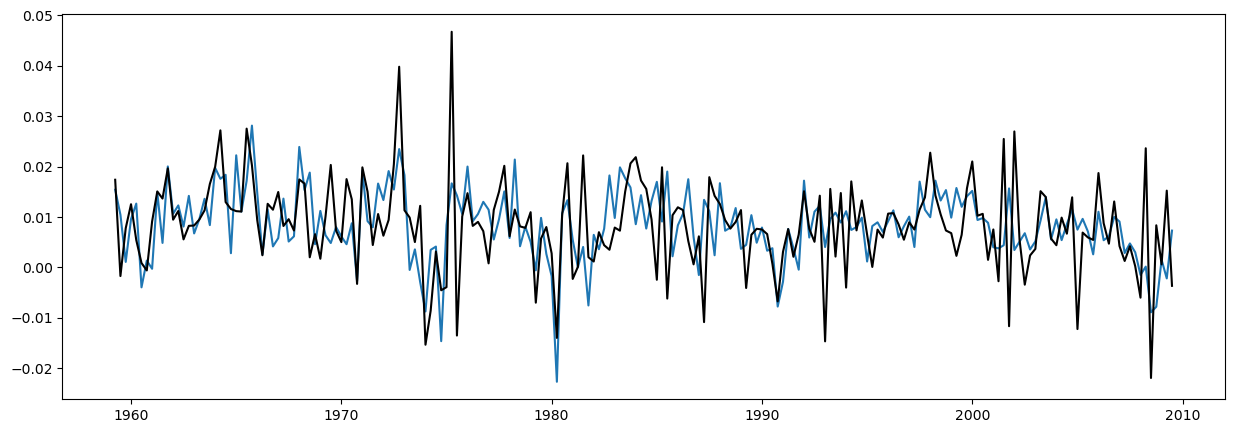

In [37]:
plt.figure(figsize=(15,5))
plt.plot(df['realcons_pct_chg'])
plt.plot(df['realdbi_pct_chg'], color='black', ls='-');

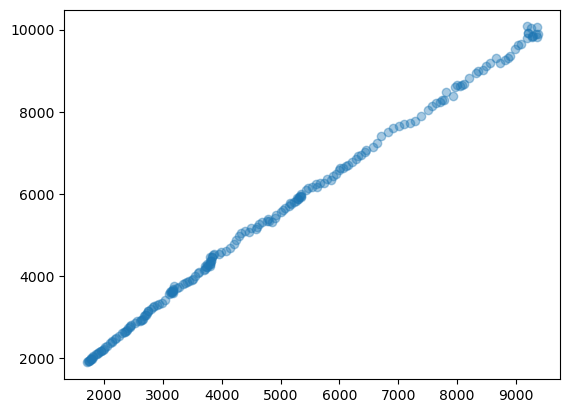

In [44]:
plt.scatter(df['realcons'], df['realdpi'], alpha=0.4);

In [45]:
df['realcons'].corr(df['realdpi'])

0.9990911886127832

In [46]:
df[['realdpi','realcons']].pct_change()

,realdpi,realcons
date,,
1959-01-01,NaN,NaN
1959-04-01,0.017383,0.015404
1959-07-01,-0.001719,0.010440
1959-10-01,0.007775,0.001085
1960-01-01,0.012530,0.009580
...,...,...
2008-07-01,-0.021941,-0.008908
2008-10-01,0.008345,-0.007812
2009-01-01,0.000605,0.001512


Flying Saucers Aren't Correlated to Flying Markets
Two trending series may show a strong correlation even if they are completely unrelated. This is referred to as "spurious correlation". That's why when you look at the correlation of say, two stocks, you should look at the correlation of their returns and not their levels.

To illustrate this point, calculate the correlation between the levels of the stock market and the annual sightings of UFOs. Both of those time series have trended up over the last several decades, and the correlation of their levels is very high. Then calculate the correlation of their percent changes. This will be close to zero, since there is no relationship between those two series.

The DataFrame levels contains the levels of DJI and UFO. UFO data was downloaded from [www.nuforc.org](www.nuforc.org).

In [8]:
p = range(0, 13, 1)
d = 1
q = range(0,13, 1)

P = range(0, 3, 1)
D = 12
Q = range(0, 3, 1)

s = 12

parameters_list = list(product(p, q, P, Q))
parameters_list[:4]

[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 1, 0)]

In [9]:
len(parameters_list)

1521

In [15]:
len(parameters_list) * 60 / 60 

1521.0